# TRF Tutorial

In this notebook we show how to import word onset as a word-level feature and compute TRF from them.

In [1]:
import os
from scipy.io import loadmat
from pyeeg.io import eeglab2mne

subj_id = 3 # id of participant (3 is subject P04)
story_id = 1 # id of stories (1 is AUNP02)

CRITICAL:pyeeg.io:Can't import Gensim (is it installed?) Will not load word vectors.


## Single subject, single story

### Import EEG

In [2]:
%gui qt

from PyQt5.QtWidgets import QFileDialog

def gui_fname(dir=None):
    """Select a directory."""
    if dir is None: dir ='./'
    fname = QFileDialog.getExistingDirectory(None, "Select directory...", dir)
    return fname

In [3]:
try:
    experiment_path = '/media/hw2512/SeagateExpansionDrive/EEG_data/Katerina_experiment'
    os.listdir('/media/hw2512/SeagateExpansionDrive/EEG_data/Katerina_experiment')
except:
    experiment_path = gui_fname()

In [4]:
eeg_path = os.path.join(experiment_path, "Processed/Fs-125/interp_bad/BP-0.3-65/Blink_pruned/")
list_subjects = os.listdir(eeg_path)
eeg_fname = [f for f in os.listdir(os.path.join(eeg_path, list_subjects[subj_id])) if f.endswith('.set')][0]

event_id = dict(boundary=-1, story_onset=1)
raw = eeglab2mne(os.path.join(eeg_path, list_subjects[subj_id], eeg_fname), load_ica=False, event_id=event_id)
raw.pick_types(eeg=True)

# Filtering the EEG
raw = raw.filter(1, 15, n_jobs=2)

/home/hugo/Work/EEG/pyEEG/pyeeg/io.py:173: DeprecationWarning: stim_channel (default True in 0.17) will change to False in 0.18 and be removed in 0.19, set it to False in 0.17 to avoid this warning
  raw = mne.io.read_raw_eeglab(input_fname=fname, montage=montage_mne, event_id=event_id, preload=True)
/home/hugo/anaconda2/envs/py36/lib/python3.6/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


Used Annotations descriptions: ['boundary', 'story_onset']
Setting up band-pass filter from 1 - 15 Hz
l_trans_bandwidth chosen to be 1.0 Hz
h_trans_bandwidth chosen to be 3.8 Hz
Filter length of 413 samples (3.304 sec) selected


/home/hugo/anaconda2/envs/py36/lib/python3.6/site-packages/mne/annotations.py:315: RuntimeWarning: invalid value encountered in less
  out_of_bounds = (absolute_onset > tmax) | (absolute_offset < tmin)
/home/hugo/anaconda2/envs/py36/lib/python3.6/site-packages/mne/annotations.py:324: RuntimeWarning: invalid value encountered in greater
  clip_right_elem = (absolute_offset > tmax) & ~out_of_bounds
/home/hugo/Work/EEG/pyEEG/pyeeg/io.py:173: RuntimeWarning: 1 events will be dropped because they occur on the same time sample as another event. `mne.io.Raw` objects store events on an event channel, which cannot represent two events on the same sample. Please use `read_annotations_eeglab` and create events using `events_from_annotations` to extract the original event structure. Then, you can e.g. subset the extracted events for constructing epochs.
  raw = mne.io.read_raw_eeglab(input_fname=fname, montage=montage_mne, event_id=event_id, preload=True)
[Parallel(n_jobs=2)]: Using backend LokyBa

### Import Word-level features

We will load _surprisal_ feature and fit a TRF model on both _word onsets_ and _surprisal_ word features.

In [25]:
# Import all paths
from pyeeg.io import WordLevelFeatures
stim_path = os.path.join(experiment_path, 'story_parts')
env_path = os.path.join(stim_path, 'alignement_data/')
wordfreq_path = os.path.join(stim_path, 'word_frequencies/')
surprisal_path = os.path.join(stim_path, 'surprisal/')
list_wordfreq_files = [item for item in os.listdir(wordfreq_path) if item.endswith('timed.csv')]
list_surprisal_files = [item for item in os.listdir(surprisal_path) if item.endswith('3.txt')]
list_stories = [item.strip('_word_freq_timed.csv') for item in list_wordfreq_files]
list_env_files = [os.path.join(env_path, s, s + '_125Hz.Env') for s in list_stories]

# Sort them all in case:
for l in [list_env_files, list_stories, list_surprisal_files, list_wordfreq_files]:
    l.sort()

onset_path = './all_katerina_onsets.mat'
onsets = loadmat(onset_path)['onsets']

# Loading word onset and duration for AUNP02:
wo_path = os.path.join(wordfreq_path, list_wordfreq_files[story_id])
duration_path = os.path.join(env_path, list_env_files[story_id])
surp_path = os.path.join(surprisal_path, list_surprisal_files[story_id])

In [26]:
# Create word-level feature object:
wf = WordLevelFeatures(path_praat_env=duration_path, path_wordonsets=wo_path, path_surprisal=surp_path)

# Creating feature matrix
x = wf.align_word_features(srate=raw.info['sfreq'], features=('surprisal',))

# Getting EEG data
y = raw.get_data()

# Croping data with indices that match current story for this participant
indices = wf.samples_from_onset(onsets[subj_id, story_id], srate=raw.info['sfreq'])
y = y[:, indices].T

INFO:pyeeg.io:Adding feature surprisal


## Run TRF modelling

The TRFEstimator class allows to use any arbitrary set of lags. The lagged time series design matrix
will be generated when fitting the class instance to aligned EEG and feature data.

In [27]:
from pyeeg.models import TRFEstimator

# TRF instance
reg_param = 0. # Ridge parameter
trf = TRFEstimator(tmin=-0.6, tmax=0.8, srate=raw.info['sfreq'], alpha=reg_param)

# Fit our model
trf.fit(x, y, feat_names=["Word Onsets", "Surprisal"])

INFO:pyeeg.models:Will use lags spanning form tmin to tmax.
To use individual lags, use the `times` argument...


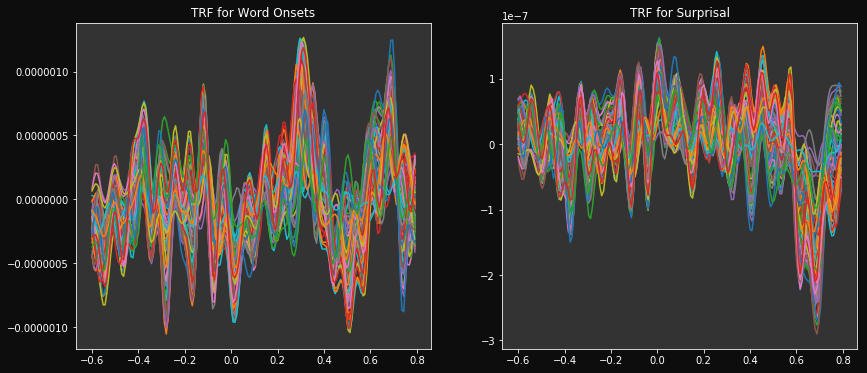

In [32]:
# Plot model:
trf.plot_single_feature(feat_id=[0,1], figsize=(14,6))

## Average several models

Let's loop the computation over all subjects and all stories to compute and grand average TRF.

In [35]:
coefs = []

# Loop over subject
for subj_id, subj in enumerate(list_subjects):
    print("="*30 + " Processing subject %s"%(subj) + "=" * 20)
    eeg_fname = [f for f in os.listdir(os.path.join(eeg_path, list_subjects[subj_id])) if f.endswith('.set')][0]
    
    # Import and process EEG:
    raw = eeglab2mne(os.path.join(eeg_path, list_subjects[subj_id], eeg_fname), load_ica=False, event_id=event_id)
    raw.pick_types(eeg=True)
    raw = raw.filter(1, 15, n_jobs=2)
    y = raw.get_data()
    
    # Loop over stories
    for story_id, story in enumerate(list_stories):
        print("\t"*4 + "... %s"%(story))
        wo_path = os.path.join(wordfreq_path, list_wordfreq_files[story_id])
        duration_path = os.path.join(env_path, list_env_files[story_id])
        surp_path = os.path.join(surprisal_path, list_surprisal_files[story_id])

        # Create word-level feature object:
        wf = WordLevelFeatures(path_praat_env=duration_path, path_wordonsets=wo_path, path_surprisal=surp_path)
        # Creating feature matrix
        x = wf.align_word_features(srate=raw.info['sfreq'], features=('surprisal',))
        indices = wf.samples_from_onset(onsets[subj_id, story_id], srate=raw.info['sfreq'])
        
        # Perform the fit:
        trf = TRFEstimator(tmin=-0.6, tmax=0.8, srate=raw.info['sfreq'], alpha=reg_param)
        trf.fit(x, y[:, indices].T, feat_names=["Word Onsets", "Surprisal"])
        
        coefs.append(trf.coef_)

============================== Processing subject P01_bis====================


/home/hugo/Work/EEG/pyEEG/pyeeg/io.py:173: DeprecationWarning: stim_channel (default True in 0.17) will change to False in 0.18 and be removed in 0.19, set it to False in 0.17 to avoid this warning
  raw = mne.io.read_raw_eeglab(input_fname=fname, montage=montage_mne, event_id=event_id, preload=True)
/home/hugo/anaconda2/envs/py36/lib/python3.6/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


Used Annotations descriptions: ['boundary', 'story_onset']
Setting up band-pass filter from 1 - 15 Hz
l_trans_bandwidth chosen to be 1.0 Hz
h_trans_bandwidth chosen to be 3.8 Hz
Filter length of 413 samples (3.304 sec) selected


/home/hugo/anaconda2/envs/py36/lib/python3.6/site-packages/mne/annotations.py:315: RuntimeWarning: invalid value encountered in less
  out_of_bounds = (absolute_onset > tmax) | (absolute_offset < tmin)
/home/hugo/anaconda2/envs/py36/lib/python3.6/site-packages/mne/annotations.py:324: RuntimeWarning: invalid value encountered in greater
  clip_right_elem = (absolute_offset > tmax) & ~out_of_bounds
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  64 out of  64 | elapsed:    0.8s finished
INFO:pyeeg.io:Adding feature surprisal
INFO:pyeeg.models:Will use lags spanning form tmin to tmax.
To use individual lags, use the `times` argument...


				... AUNP01


INFO:pyeeg.io:Adding feature surprisal
INFO:pyeeg.models:Will use lags spanning form tmin to tmax.
To use individual lags, use the `times` argument...


				... AUNP02
				... AUNP03


INFO:pyeeg.io:Adding feature surprisal
INFO:pyeeg.models:Will use lags spanning form tmin to tmax.
To use individual lags, use the `times` argument...
INFO:pyeeg.io:Adding feature surprisal
INFO:pyeeg.models:Will use lags spanning form tmin to tmax.
To use individual lags, use the `times` argument...


				... AUNP04


INFO:pyeeg.io:Adding feature surprisal
INFO:pyeeg.models:Will use lags spanning form tmin to tmax.
To use individual lags, use the `times` argument...


				... AUNP05


INFO:pyeeg.io:Adding feature surprisal
INFO:pyeeg.models:Will use lags spanning form tmin to tmax.
To use individual lags, use the `times` argument...


				... AUNP06


INFO:pyeeg.io:Adding feature surprisal
INFO:pyeeg.models:Will use lags spanning form tmin to tmax.
To use individual lags, use the `times` argument...


				... AUNP07


INFO:pyeeg.io:Adding feature surprisal
INFO:pyeeg.models:Will use lags spanning form tmin to tmax.
To use individual lags, use the `times` argument...


				... AUNP08


INFO:pyeeg.io:Adding feature surprisal
INFO:pyeeg.models:Will use lags spanning form tmin to tmax.
To use individual lags, use the `times` argument...


				... BROP01


INFO:pyeeg.io:Adding feature surprisal
INFO:pyeeg.models:Will use lags spanning form tmin to tmax.
To use individual lags, use the `times` argument...


				... BROP02


INFO:pyeeg.io:Adding feature surprisal
INFO:pyeeg.models:Will use lags spanning form tmin to tmax.
To use individual lags, use the `times` argument...


				... BROP03


INFO:pyeeg.io:Adding feature surprisal
INFO:pyeeg.models:Will use lags spanning form tmin to tmax.
To use individual lags, use the `times` argument...


				... FLOP01


INFO:pyeeg.io:Adding feature surprisal
INFO:pyeeg.models:Will use lags spanning form tmin to tmax.
To use individual lags, use the `times` argument...


				... FLOP02


INFO:pyeeg.io:Adding feature surprisal
INFO:pyeeg.models:Will use lags spanning form tmin to tmax.
To use individual lags, use the `times` argument...


				... FLOP03


INFO:pyeeg.io:Adding feature surprisal
INFO:pyeeg.models:Will use lags spanning form tmin to tmax.
To use individual lags, use the `times` argument...


				... FLOP04
============================== Processing subject P02_11072016====================


/home/hugo/Work/EEG/pyEEG/pyeeg/io.py:173: DeprecationWarning: stim_channel (default True in 0.17) will change to False in 0.18 and be removed in 0.19, set it to False in 0.17 to avoid this warning
  raw = mne.io.read_raw_eeglab(input_fname=fname, montage=montage_mne, event_id=event_id, preload=True)


Used Annotations descriptions: ['boundary', 'story_onset']
Setting up band-pass filter from 1 - 15 Hz
l_trans_bandwidth chosen to be 1.0 Hz
h_trans_bandwidth chosen to be 3.8 Hz
Filter length of 413 samples (3.304 sec) selected


/home/hugo/Work/EEG/pyEEG/pyeeg/io.py:173: RuntimeWarning: 1 events will be dropped because they occur on the same time sample as another event. `mne.io.Raw` objects store events on an event channel, which cannot represent two events on the same sample. Please use `read_annotations_eeglab` and create events using `events_from_annotations` to extract the original event structure. Then, you can e.g. subset the extracted events for constructing epochs.
  raw = mne.io.read_raw_eeglab(input_fname=fname, montage=montage_mne, event_id=event_id, preload=True)
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  64 out of  64 | elapsed:    0.8s finished
INFO:pyeeg.io:Adding feature surprisal
INFO:pyeeg.models:Will use lags spanning form tmin to tmax.
To use individual lags, use the `times` argument...


				... AUNP01


INFO:pyeeg.io:Adding feature surprisal
INFO:pyeeg.models:Will use lags spanning form tmin to tmax.
To use individual lags, use the `times` argument...


				... AUNP02


INFO:pyeeg.io:Adding feature surprisal
INFO:pyeeg.models:Will use lags spanning form tmin to tmax.
To use individual lags, use the `times` argument...


				... AUNP03


INFO:pyeeg.io:Adding feature surprisal
INFO:pyeeg.models:Will use lags spanning form tmin to tmax.
To use individual lags, use the `times` argument...


				... AUNP04


INFO:pyeeg.io:Adding feature surprisal
INFO:pyeeg.models:Will use lags spanning form tmin to tmax.
To use individual lags, use the `times` argument...


				... AUNP05


INFO:pyeeg.io:Adding feature surprisal
INFO:pyeeg.models:Will use lags spanning form tmin to tmax.
To use individual lags, use the `times` argument...


				... AUNP06


INFO:pyeeg.io:Adding feature surprisal
INFO:pyeeg.models:Will use lags spanning form tmin to tmax.
To use individual lags, use the `times` argument...


				... AUNP07


INFO:pyeeg.io:Adding feature surprisal
INFO:pyeeg.models:Will use lags spanning form tmin to tmax.
To use individual lags, use the `times` argument...


				... AUNP08


INFO:pyeeg.io:Adding feature surprisal
INFO:pyeeg.models:Will use lags spanning form tmin to tmax.
To use individual lags, use the `times` argument...


				... BROP01


INFO:pyeeg.io:Adding feature surprisal
INFO:pyeeg.models:Will use lags spanning form tmin to tmax.
To use individual lags, use the `times` argument...


				... BROP02


INFO:pyeeg.io:Adding feature surprisal
INFO:pyeeg.models:Will use lags spanning form tmin to tmax.
To use individual lags, use the `times` argument...


				... BROP03


INFO:pyeeg.io:Adding feature surprisal
INFO:pyeeg.models:Will use lags spanning form tmin to tmax.
To use individual lags, use the `times` argument...


				... FLOP01


INFO:pyeeg.io:Adding feature surprisal
INFO:pyeeg.models:Will use lags spanning form tmin to tmax.
To use individual lags, use the `times` argument...


				... FLOP02


INFO:pyeeg.io:Adding feature surprisal
INFO:pyeeg.models:Will use lags spanning form tmin to tmax.
To use individual lags, use the `times` argument...


				... FLOP03


INFO:pyeeg.io:Adding feature surprisal
INFO:pyeeg.models:Will use lags spanning form tmin to tmax.
To use individual lags, use the `times` argument...


				... FLOP04
============================== Processing subject P03_12072016====================


/home/hugo/Work/EEG/pyEEG/pyeeg/io.py:173: DeprecationWarning: stim_channel (default True in 0.17) will change to False in 0.18 and be removed in 0.19, set it to False in 0.17 to avoid this warning
  raw = mne.io.read_raw_eeglab(input_fname=fname, montage=montage_mne, event_id=event_id, preload=True)


Used Annotations descriptions: ['boundary', 'story_onset']
Setting up band-pass filter from 1 - 15 Hz
l_trans_bandwidth chosen to be 1.0 Hz
h_trans_bandwidth chosen to be 3.8 Hz
Filter length of 413 samples (3.304 sec) selected


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  64 out of  64 | elapsed:    0.8s finished
INFO:pyeeg.io:Adding feature surprisal
INFO:pyeeg.models:Will use lags spanning form tmin to tmax.
To use individual lags, use the `times` argument...


				... AUNP01


INFO:pyeeg.io:Adding feature surprisal
INFO:pyeeg.models:Will use lags spanning form tmin to tmax.
To use individual lags, use the `times` argument...


				... AUNP02


INFO:pyeeg.io:Adding feature surprisal
INFO:pyeeg.models:Will use lags spanning form tmin to tmax.
To use individual lags, use the `times` argument...


				... AUNP03


INFO:pyeeg.io:Adding feature surprisal
INFO:pyeeg.models:Will use lags spanning form tmin to tmax.
To use individual lags, use the `times` argument...


				... AUNP04


INFO:pyeeg.io:Adding feature surprisal
INFO:pyeeg.models:Will use lags spanning form tmin to tmax.
To use individual lags, use the `times` argument...


				... AUNP05


INFO:pyeeg.io:Adding feature surprisal
INFO:pyeeg.models:Will use lags spanning form tmin to tmax.
To use individual lags, use the `times` argument...


				... AUNP06


INFO:pyeeg.io:Adding feature surprisal
INFO:pyeeg.models:Will use lags spanning form tmin to tmax.
To use individual lags, use the `times` argument...


				... AUNP07


INFO:pyeeg.io:Adding feature surprisal
INFO:pyeeg.models:Will use lags spanning form tmin to tmax.
To use individual lags, use the `times` argument...


				... AUNP08


INFO:pyeeg.io:Adding feature surprisal
INFO:pyeeg.models:Will use lags spanning form tmin to tmax.
To use individual lags, use the `times` argument...


				... BROP01


INFO:pyeeg.io:Adding feature surprisal
INFO:pyeeg.models:Will use lags spanning form tmin to tmax.
To use individual lags, use the `times` argument...


				... BROP02


INFO:pyeeg.io:Adding feature surprisal
INFO:pyeeg.models:Will use lags spanning form tmin to tmax.
To use individual lags, use the `times` argument...


				... BROP03


INFO:pyeeg.io:Adding feature surprisal
INFO:pyeeg.models:Will use lags spanning form tmin to tmax.
To use individual lags, use the `times` argument...


				... FLOP01


INFO:pyeeg.io:Adding feature surprisal
INFO:pyeeg.models:Will use lags spanning form tmin to tmax.
To use individual lags, use the `times` argument...


				... FLOP02


INFO:pyeeg.io:Adding feature surprisal
INFO:pyeeg.models:Will use lags spanning form tmin to tmax.
To use individual lags, use the `times` argument...


				... FLOP03


INFO:pyeeg.io:Adding feature surprisal
INFO:pyeeg.models:Will use lags spanning form tmin to tmax.
To use individual lags, use the `times` argument...


				... FLOP04
============================== Processing subject P04_13072016====================


/home/hugo/Work/EEG/pyEEG/pyeeg/io.py:173: DeprecationWarning: stim_channel (default True in 0.17) will change to False in 0.18 and be removed in 0.19, set it to False in 0.17 to avoid this warning
  raw = mne.io.read_raw_eeglab(input_fname=fname, montage=montage_mne, event_id=event_id, preload=True)


Used Annotations descriptions: ['boundary', 'story_onset']
Setting up band-pass filter from 1 - 15 Hz
l_trans_bandwidth chosen to be 1.0 Hz
h_trans_bandwidth chosen to be 3.8 Hz
Filter length of 413 samples (3.304 sec) selected


/home/hugo/Work/EEG/pyEEG/pyeeg/io.py:173: RuntimeWarning: 1 events will be dropped because they occur on the same time sample as another event. `mne.io.Raw` objects store events on an event channel, which cannot represent two events on the same sample. Please use `read_annotations_eeglab` and create events using `events_from_annotations` to extract the original event structure. Then, you can e.g. subset the extracted events for constructing epochs.
  raw = mne.io.read_raw_eeglab(input_fname=fname, montage=montage_mne, event_id=event_id, preload=True)
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  64 out of  64 | elapsed:    0.8s finished
INFO:pyeeg.io:Adding feature surprisal
INFO:pyeeg.models:Will use lags spanning form tmin to tmax.
To use individual lags, use the `times` argument...


				... AUNP01


INFO:pyeeg.io:Adding feature surprisal
INFO:pyeeg.models:Will use lags spanning form tmin to tmax.
To use individual lags, use the `times` argument...


				... AUNP02


INFO:pyeeg.io:Adding feature surprisal
INFO:pyeeg.models:Will use lags spanning form tmin to tmax.
To use individual lags, use the `times` argument...


				... AUNP03


INFO:pyeeg.io:Adding feature surprisal
INFO:pyeeg.models:Will use lags spanning form tmin to tmax.
To use individual lags, use the `times` argument...


				... AUNP04


INFO:pyeeg.io:Adding feature surprisal
INFO:pyeeg.models:Will use lags spanning form tmin to tmax.
To use individual lags, use the `times` argument...


				... AUNP05


INFO:pyeeg.io:Adding feature surprisal
INFO:pyeeg.models:Will use lags spanning form tmin to tmax.
To use individual lags, use the `times` argument...


				... AUNP06


INFO:pyeeg.io:Adding feature surprisal
INFO:pyeeg.models:Will use lags spanning form tmin to tmax.
To use individual lags, use the `times` argument...


				... AUNP07


INFO:pyeeg.io:Adding feature surprisal
INFO:pyeeg.models:Will use lags spanning form tmin to tmax.
To use individual lags, use the `times` argument...


				... AUNP08


INFO:pyeeg.io:Adding feature surprisal
INFO:pyeeg.models:Will use lags spanning form tmin to tmax.
To use individual lags, use the `times` argument...


				... BROP01


INFO:pyeeg.io:Adding feature surprisal
INFO:pyeeg.models:Will use lags spanning form tmin to tmax.
To use individual lags, use the `times` argument...


				... BROP02


INFO:pyeeg.io:Adding feature surprisal
INFO:pyeeg.models:Will use lags spanning form tmin to tmax.
To use individual lags, use the `times` argument...


				... BROP03


INFO:pyeeg.io:Adding feature surprisal
INFO:pyeeg.models:Will use lags spanning form tmin to tmax.
To use individual lags, use the `times` argument...


				... FLOP01


INFO:pyeeg.io:Adding feature surprisal
INFO:pyeeg.models:Will use lags spanning form tmin to tmax.
To use individual lags, use the `times` argument...


				... FLOP02


INFO:pyeeg.io:Adding feature surprisal
INFO:pyeeg.models:Will use lags spanning form tmin to tmax.
To use individual lags, use the `times` argument...


				... FLOP03


INFO:pyeeg.io:Adding feature surprisal
INFO:pyeeg.models:Will use lags spanning form tmin to tmax.
To use individual lags, use the `times` argument...


				... FLOP04
============================== Processing subject P05_14072016====================


/home/hugo/Work/EEG/pyEEG/pyeeg/io.py:173: DeprecationWarning: stim_channel (default True in 0.17) will change to False in 0.18 and be removed in 0.19, set it to False in 0.17 to avoid this warning
  raw = mne.io.read_raw_eeglab(input_fname=fname, montage=montage_mne, event_id=event_id, preload=True)


Used Annotations descriptions: ['boundary', 'story_onset']
Setting up band-pass filter from 1 - 15 Hz
l_trans_bandwidth chosen to be 1.0 Hz
h_trans_bandwidth chosen to be 3.8 Hz
Filter length of 413 samples (3.304 sec) selected


/home/hugo/Work/EEG/pyEEG/pyeeg/io.py:173: RuntimeWarning: 1 events will be dropped because they occur on the same time sample as another event. `mne.io.Raw` objects store events on an event channel, which cannot represent two events on the same sample. Please use `read_annotations_eeglab` and create events using `events_from_annotations` to extract the original event structure. Then, you can e.g. subset the extracted events for constructing epochs.
  raw = mne.io.read_raw_eeglab(input_fname=fname, montage=montage_mne, event_id=event_id, preload=True)
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  64 out of  64 | elapsed:    0.8s finished
INFO:pyeeg.io:Adding feature surprisal
INFO:pyeeg.models:Will use lags spanning form tmin to tmax.
To use individual lags, use the `times` argument...


				... AUNP01


INFO:pyeeg.io:Adding feature surprisal
INFO:pyeeg.models:Will use lags spanning form tmin to tmax.
To use individual lags, use the `times` argument...


				... AUNP02


INFO:pyeeg.io:Adding feature surprisal
INFO:pyeeg.models:Will use lags spanning form tmin to tmax.
To use individual lags, use the `times` argument...


				... AUNP03


INFO:pyeeg.io:Adding feature surprisal
INFO:pyeeg.models:Will use lags spanning form tmin to tmax.
To use individual lags, use the `times` argument...


				... AUNP04


INFO:pyeeg.io:Adding feature surprisal
INFO:pyeeg.models:Will use lags spanning form tmin to tmax.
To use individual lags, use the `times` argument...


				... AUNP05


INFO:pyeeg.io:Adding feature surprisal
INFO:pyeeg.models:Will use lags spanning form tmin to tmax.
To use individual lags, use the `times` argument...


				... AUNP06


INFO:pyeeg.io:Adding feature surprisal
INFO:pyeeg.models:Will use lags spanning form tmin to tmax.
To use individual lags, use the `times` argument...


				... AUNP07


INFO:pyeeg.io:Adding feature surprisal
INFO:pyeeg.models:Will use lags spanning form tmin to tmax.
To use individual lags, use the `times` argument...


				... AUNP08


INFO:pyeeg.io:Adding feature surprisal
INFO:pyeeg.models:Will use lags spanning form tmin to tmax.
To use individual lags, use the `times` argument...


				... BROP01


INFO:pyeeg.io:Adding feature surprisal
INFO:pyeeg.models:Will use lags spanning form tmin to tmax.
To use individual lags, use the `times` argument...


				... BROP02


INFO:pyeeg.io:Adding feature surprisal
INFO:pyeeg.models:Will use lags spanning form tmin to tmax.
To use individual lags, use the `times` argument...


				... BROP03


INFO:pyeeg.io:Adding feature surprisal
INFO:pyeeg.models:Will use lags spanning form tmin to tmax.
To use individual lags, use the `times` argument...


				... FLOP01


INFO:pyeeg.io:Adding feature surprisal
INFO:pyeeg.models:Will use lags spanning form tmin to tmax.
To use individual lags, use the `times` argument...


				... FLOP02


INFO:pyeeg.io:Adding feature surprisal
INFO:pyeeg.models:Will use lags spanning form tmin to tmax.
To use individual lags, use the `times` argument...


				... FLOP03


INFO:pyeeg.io:Adding feature surprisal
INFO:pyeeg.models:Will use lags spanning form tmin to tmax.
To use individual lags, use the `times` argument...


				... FLOP04
============================== Processing subject P06_18072016====================


/home/hugo/Work/EEG/pyEEG/pyeeg/io.py:173: DeprecationWarning: stim_channel (default True in 0.17) will change to False in 0.18 and be removed in 0.19, set it to False in 0.17 to avoid this warning
  raw = mne.io.read_raw_eeglab(input_fname=fname, montage=montage_mne, event_id=event_id, preload=True)


Used Annotations descriptions: ['boundary', 'story_onset']
Setting up band-pass filter from 1 - 15 Hz
l_trans_bandwidth chosen to be 1.0 Hz
h_trans_bandwidth chosen to be 3.8 Hz
Filter length of 413 samples (3.304 sec) selected


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  64 out of  64 | elapsed:    0.8s finished
INFO:pyeeg.io:Adding feature surprisal
INFO:pyeeg.models:Will use lags spanning form tmin to tmax.
To use individual lags, use the `times` argument...


				... AUNP01


INFO:pyeeg.io:Adding feature surprisal
INFO:pyeeg.models:Will use lags spanning form tmin to tmax.
To use individual lags, use the `times` argument...


				... AUNP02


INFO:pyeeg.io:Adding feature surprisal
INFO:pyeeg.models:Will use lags spanning form tmin to tmax.
To use individual lags, use the `times` argument...


				... AUNP03


INFO:pyeeg.io:Adding feature surprisal
INFO:pyeeg.models:Will use lags spanning form tmin to tmax.
To use individual lags, use the `times` argument...


				... AUNP04


INFO:pyeeg.io:Adding feature surprisal
INFO:pyeeg.models:Will use lags spanning form tmin to tmax.
To use individual lags, use the `times` argument...


				... AUNP05


INFO:pyeeg.io:Adding feature surprisal
INFO:pyeeg.models:Will use lags spanning form tmin to tmax.
To use individual lags, use the `times` argument...


				... AUNP06


INFO:pyeeg.io:Adding feature surprisal
INFO:pyeeg.models:Will use lags spanning form tmin to tmax.
To use individual lags, use the `times` argument...


				... AUNP07


INFO:pyeeg.io:Adding feature surprisal
INFO:pyeeg.models:Will use lags spanning form tmin to tmax.
To use individual lags, use the `times` argument...


				... AUNP08


INFO:pyeeg.io:Adding feature surprisal
INFO:pyeeg.models:Will use lags spanning form tmin to tmax.
To use individual lags, use the `times` argument...


				... BROP01


INFO:pyeeg.io:Adding feature surprisal
INFO:pyeeg.models:Will use lags spanning form tmin to tmax.
To use individual lags, use the `times` argument...


				... BROP02


INFO:pyeeg.io:Adding feature surprisal
INFO:pyeeg.models:Will use lags spanning form tmin to tmax.
To use individual lags, use the `times` argument...


				... BROP03


INFO:pyeeg.io:Adding feature surprisal
INFO:pyeeg.models:Will use lags spanning form tmin to tmax.
To use individual lags, use the `times` argument...


				... FLOP01


INFO:pyeeg.io:Adding feature surprisal
INFO:pyeeg.models:Will use lags spanning form tmin to tmax.
To use individual lags, use the `times` argument...


				... FLOP02


INFO:pyeeg.io:Adding feature surprisal
INFO:pyeeg.models:Will use lags spanning form tmin to tmax.
To use individual lags, use the `times` argument...


				... FLOP03


INFO:pyeeg.io:Adding feature surprisal
INFO:pyeeg.models:Will use lags spanning form tmin to tmax.
To use individual lags, use the `times` argument...


				... FLOP04
============================== Processing subject P07_19072016====================


/home/hugo/Work/EEG/pyEEG/pyeeg/io.py:173: DeprecationWarning: stim_channel (default True in 0.17) will change to False in 0.18 and be removed in 0.19, set it to False in 0.17 to avoid this warning
  raw = mne.io.read_raw_eeglab(input_fname=fname, montage=montage_mne, event_id=event_id, preload=True)


Used Annotations descriptions: ['boundary', 'story_onset']
Setting up band-pass filter from 1 - 15 Hz
l_trans_bandwidth chosen to be 1.0 Hz
h_trans_bandwidth chosen to be 3.8 Hz
Filter length of 413 samples (3.304 sec) selected


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  64 out of  64 | elapsed:    0.7s finished
INFO:pyeeg.io:Adding feature surprisal
INFO:pyeeg.models:Will use lags spanning form tmin to tmax.
To use individual lags, use the `times` argument...


				... AUNP01


INFO:pyeeg.io:Adding feature surprisal
INFO:pyeeg.models:Will use lags spanning form tmin to tmax.
To use individual lags, use the `times` argument...


				... AUNP02


INFO:pyeeg.io:Adding feature surprisal
INFO:pyeeg.models:Will use lags spanning form tmin to tmax.
To use individual lags, use the `times` argument...


				... AUNP03


INFO:pyeeg.io:Adding feature surprisal
INFO:pyeeg.models:Will use lags spanning form tmin to tmax.
To use individual lags, use the `times` argument...


				... AUNP04


INFO:pyeeg.io:Adding feature surprisal
INFO:pyeeg.models:Will use lags spanning form tmin to tmax.
To use individual lags, use the `times` argument...


				... AUNP05


INFO:pyeeg.io:Adding feature surprisal
INFO:pyeeg.models:Will use lags spanning form tmin to tmax.
To use individual lags, use the `times` argument...


				... AUNP06


INFO:pyeeg.io:Adding feature surprisal
INFO:pyeeg.models:Will use lags spanning form tmin to tmax.
To use individual lags, use the `times` argument...


				... AUNP07


INFO:pyeeg.io:Adding feature surprisal
INFO:pyeeg.models:Will use lags spanning form tmin to tmax.
To use individual lags, use the `times` argument...


				... AUNP08


INFO:pyeeg.io:Adding feature surprisal
INFO:pyeeg.models:Will use lags spanning form tmin to tmax.
To use individual lags, use the `times` argument...


				... BROP01


INFO:pyeeg.io:Adding feature surprisal
INFO:pyeeg.models:Will use lags spanning form tmin to tmax.
To use individual lags, use the `times` argument...


				... BROP02


INFO:pyeeg.io:Adding feature surprisal
INFO:pyeeg.models:Will use lags spanning form tmin to tmax.
To use individual lags, use the `times` argument...


				... BROP03


INFO:pyeeg.io:Adding feature surprisal
INFO:pyeeg.models:Will use lags spanning form tmin to tmax.
To use individual lags, use the `times` argument...


				... FLOP01


INFO:pyeeg.io:Adding feature surprisal
INFO:pyeeg.models:Will use lags spanning form tmin to tmax.
To use individual lags, use the `times` argument...


				... FLOP02


INFO:pyeeg.io:Adding feature surprisal
INFO:pyeeg.models:Will use lags spanning form tmin to tmax.
To use individual lags, use the `times` argument...


				... FLOP03


INFO:pyeeg.io:Adding feature surprisal
INFO:pyeeg.models:Will use lags spanning form tmin to tmax.
To use individual lags, use the `times` argument...


				... FLOP04
============================== Processing subject P08_21072016====================


/home/hugo/Work/EEG/pyEEG/pyeeg/io.py:173: DeprecationWarning: stim_channel (default True in 0.17) will change to False in 0.18 and be removed in 0.19, set it to False in 0.17 to avoid this warning
  raw = mne.io.read_raw_eeglab(input_fname=fname, montage=montage_mne, event_id=event_id, preload=True)


Used Annotations descriptions: ['boundary', 'story_onset']
Setting up band-pass filter from 1 - 15 Hz
l_trans_bandwidth chosen to be 1.0 Hz
h_trans_bandwidth chosen to be 3.8 Hz
Filter length of 413 samples (3.304 sec) selected


/home/hugo/Work/EEG/pyEEG/pyeeg/io.py:173: RuntimeWarning: 1 events will be dropped because they occur on the same time sample as another event. `mne.io.Raw` objects store events on an event channel, which cannot represent two events on the same sample. Please use `read_annotations_eeglab` and create events using `events_from_annotations` to extract the original event structure. Then, you can e.g. subset the extracted events for constructing epochs.
  raw = mne.io.read_raw_eeglab(input_fname=fname, montage=montage_mne, event_id=event_id, preload=True)
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  64 out of  64 | elapsed:    0.7s finished
INFO:pyeeg.io:Adding feature surprisal
INFO:pyeeg.models:Will use lags spanning form tmin to tmax.
To use individual lags, use the `times` argument...


				... AUNP01


INFO:pyeeg.io:Adding feature surprisal
INFO:pyeeg.models:Will use lags spanning form tmin to tmax.
To use individual lags, use the `times` argument...


				... AUNP02


INFO:pyeeg.io:Adding feature surprisal
INFO:pyeeg.models:Will use lags spanning form tmin to tmax.
To use individual lags, use the `times` argument...


				... AUNP03


INFO:pyeeg.io:Adding feature surprisal
INFO:pyeeg.models:Will use lags spanning form tmin to tmax.
To use individual lags, use the `times` argument...


				... AUNP04


INFO:pyeeg.io:Adding feature surprisal
INFO:pyeeg.models:Will use lags spanning form tmin to tmax.
To use individual lags, use the `times` argument...


				... AUNP05


INFO:pyeeg.io:Adding feature surprisal
INFO:pyeeg.models:Will use lags spanning form tmin to tmax.
To use individual lags, use the `times` argument...


				... AUNP06


INFO:pyeeg.io:Adding feature surprisal
INFO:pyeeg.models:Will use lags spanning form tmin to tmax.
To use individual lags, use the `times` argument...


				... AUNP07


INFO:pyeeg.io:Adding feature surprisal
INFO:pyeeg.models:Will use lags spanning form tmin to tmax.
To use individual lags, use the `times` argument...


				... AUNP08


INFO:pyeeg.io:Adding feature surprisal
INFO:pyeeg.models:Will use lags spanning form tmin to tmax.
To use individual lags, use the `times` argument...


				... BROP01


INFO:pyeeg.io:Adding feature surprisal
INFO:pyeeg.models:Will use lags spanning form tmin to tmax.
To use individual lags, use the `times` argument...


				... BROP02


INFO:pyeeg.io:Adding feature surprisal
INFO:pyeeg.models:Will use lags spanning form tmin to tmax.
To use individual lags, use the `times` argument...


				... BROP03


INFO:pyeeg.io:Adding feature surprisal
INFO:pyeeg.models:Will use lags spanning form tmin to tmax.
To use individual lags, use the `times` argument...


				... FLOP01


INFO:pyeeg.io:Adding feature surprisal
INFO:pyeeg.models:Will use lags spanning form tmin to tmax.
To use individual lags, use the `times` argument...


				... FLOP02


INFO:pyeeg.io:Adding feature surprisal
INFO:pyeeg.models:Will use lags spanning form tmin to tmax.
To use individual lags, use the `times` argument...


				... FLOP03


INFO:pyeeg.io:Adding feature surprisal
INFO:pyeeg.models:Will use lags spanning form tmin to tmax.
To use individual lags, use the `times` argument...


				... FLOP04
============================== Processing subject P09_22072016====================


/home/hugo/Work/EEG/pyEEG/pyeeg/io.py:173: DeprecationWarning: stim_channel (default True in 0.17) will change to False in 0.18 and be removed in 0.19, set it to False in 0.17 to avoid this warning
  raw = mne.io.read_raw_eeglab(input_fname=fname, montage=montage_mne, event_id=event_id, preload=True)


Used Annotations descriptions: ['boundary', 'story_onset', 'S  4', 'S  8', 'S  3', 'S  2', 'S  1']
Setting up band-pass filter from 1 - 15 Hz
l_trans_bandwidth chosen to be 1.0 Hz
h_trans_bandwidth chosen to be 3.8 Hz
Filter length of 413 samples (3.304 sec) selected


/home/hugo/Work/EEG/pyEEG/pyeeg/io.py:173: RuntimeWarning: 1 events will be dropped because they occur on the same time sample as another event. `mne.io.Raw` objects store events on an event channel, which cannot represent two events on the same sample. Please use `read_annotations_eeglab` and create events using `events_from_annotations` to extract the original event structure. Then, you can e.g. subset the extracted events for constructing epochs.
  raw = mne.io.read_raw_eeglab(input_fname=fname, montage=montage_mne, event_id=event_id, preload=True)
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  64 out of  64 | elapsed:    1.0s finished
INFO:pyeeg.io:Adding feature surprisal
INFO:pyeeg.models:Will use lags spanning form tmin to tmax.
To use individual lags, use the `times` argument...


				... AUNP01


INFO:pyeeg.io:Adding feature surprisal
INFO:pyeeg.models:Will use lags spanning form tmin to tmax.
To use individual lags, use the `times` argument...


				... AUNP02


INFO:pyeeg.io:Adding feature surprisal
INFO:pyeeg.models:Will use lags spanning form tmin to tmax.
To use individual lags, use the `times` argument...


				... AUNP03


INFO:pyeeg.io:Adding feature surprisal
INFO:pyeeg.models:Will use lags spanning form tmin to tmax.
To use individual lags, use the `times` argument...


				... AUNP04


INFO:pyeeg.io:Adding feature surprisal
INFO:pyeeg.models:Will use lags spanning form tmin to tmax.
To use individual lags, use the `times` argument...


				... AUNP05


INFO:pyeeg.io:Adding feature surprisal
INFO:pyeeg.models:Will use lags spanning form tmin to tmax.
To use individual lags, use the `times` argument...


				... AUNP06


INFO:pyeeg.io:Adding feature surprisal
INFO:pyeeg.models:Will use lags spanning form tmin to tmax.
To use individual lags, use the `times` argument...


				... AUNP07


INFO:pyeeg.io:Adding feature surprisal
INFO:pyeeg.models:Will use lags spanning form tmin to tmax.
To use individual lags, use the `times` argument...


				... AUNP08


INFO:pyeeg.io:Adding feature surprisal
INFO:pyeeg.models:Will use lags spanning form tmin to tmax.
To use individual lags, use the `times` argument...


				... BROP01


INFO:pyeeg.io:Adding feature surprisal
INFO:pyeeg.models:Will use lags spanning form tmin to tmax.
To use individual lags, use the `times` argument...


				... BROP02


INFO:pyeeg.io:Adding feature surprisal
INFO:pyeeg.models:Will use lags spanning form tmin to tmax.
To use individual lags, use the `times` argument...


				... BROP03


INFO:pyeeg.io:Adding feature surprisal
INFO:pyeeg.models:Will use lags spanning form tmin to tmax.
To use individual lags, use the `times` argument...


				... FLOP01


INFO:pyeeg.io:Adding feature surprisal
INFO:pyeeg.models:Will use lags spanning form tmin to tmax.
To use individual lags, use the `times` argument...


				... FLOP02


INFO:pyeeg.io:Adding feature surprisal
INFO:pyeeg.models:Will use lags spanning form tmin to tmax.
To use individual lags, use the `times` argument...


				... FLOP03


INFO:pyeeg.io:Adding feature surprisal
INFO:pyeeg.models:Will use lags spanning form tmin to tmax.
To use individual lags, use the `times` argument...


				... FLOP04
============================== Processing subject P10_14092016====================


/home/hugo/Work/EEG/pyEEG/pyeeg/io.py:173: DeprecationWarning: stim_channel (default True in 0.17) will change to False in 0.18 and be removed in 0.19, set it to False in 0.17 to avoid this warning
  raw = mne.io.read_raw_eeglab(input_fname=fname, montage=montage_mne, event_id=event_id, preload=True)


Used Annotations descriptions: ['boundary', 'S  4', 'story_onset', 'S  8', 'S  3', 'S  2', 'S  1']
Setting up band-pass filter from 1 - 15 Hz
l_trans_bandwidth chosen to be 1.0 Hz
h_trans_bandwidth chosen to be 3.8 Hz
Filter length of 413 samples (3.304 sec) selected


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  64 out of  64 | elapsed:    0.8s finished
INFO:pyeeg.io:Adding feature surprisal
INFO:pyeeg.models:Will use lags spanning form tmin to tmax.
To use individual lags, use the `times` argument...


				... AUNP01


INFO:pyeeg.io:Adding feature surprisal
INFO:pyeeg.models:Will use lags spanning form tmin to tmax.
To use individual lags, use the `times` argument...


				... AUNP02


INFO:pyeeg.io:Adding feature surprisal
INFO:pyeeg.models:Will use lags spanning form tmin to tmax.
To use individual lags, use the `times` argument...


				... AUNP03


INFO:pyeeg.io:Adding feature surprisal
INFO:pyeeg.models:Will use lags spanning form tmin to tmax.
To use individual lags, use the `times` argument...


				... AUNP04


INFO:pyeeg.io:Adding feature surprisal
INFO:pyeeg.models:Will use lags spanning form tmin to tmax.
To use individual lags, use the `times` argument...


				... AUNP05


INFO:pyeeg.io:Adding feature surprisal
INFO:pyeeg.models:Will use lags spanning form tmin to tmax.
To use individual lags, use the `times` argument...


				... AUNP06


INFO:pyeeg.io:Adding feature surprisal
INFO:pyeeg.models:Will use lags spanning form tmin to tmax.
To use individual lags, use the `times` argument...


				... AUNP07


INFO:pyeeg.io:Adding feature surprisal
INFO:pyeeg.models:Will use lags spanning form tmin to tmax.
To use individual lags, use the `times` argument...


				... AUNP08


INFO:pyeeg.io:Adding feature surprisal
INFO:pyeeg.models:Will use lags spanning form tmin to tmax.
To use individual lags, use the `times` argument...


				... BROP01


INFO:pyeeg.io:Adding feature surprisal
INFO:pyeeg.models:Will use lags spanning form tmin to tmax.
To use individual lags, use the `times` argument...


				... BROP02


INFO:pyeeg.io:Adding feature surprisal
INFO:pyeeg.models:Will use lags spanning form tmin to tmax.
To use individual lags, use the `times` argument...


				... BROP03


INFO:pyeeg.io:Adding feature surprisal
INFO:pyeeg.models:Will use lags spanning form tmin to tmax.
To use individual lags, use the `times` argument...


				... FLOP01


INFO:pyeeg.io:Adding feature surprisal
INFO:pyeeg.models:Will use lags spanning form tmin to tmax.
To use individual lags, use the `times` argument...


				... FLOP02


INFO:pyeeg.io:Adding feature surprisal
INFO:pyeeg.models:Will use lags spanning form tmin to tmax.
To use individual lags, use the `times` argument...


				... FLOP03


INFO:pyeeg.io:Adding feature surprisal
INFO:pyeeg.models:Will use lags spanning form tmin to tmax.
To use individual lags, use the `times` argument...


				... FLOP04
============================== Processing subject P12_01092016====================


/home/hugo/Work/EEG/pyEEG/pyeeg/io.py:173: DeprecationWarning: stim_channel (default True in 0.17) will change to False in 0.18 and be removed in 0.19, set it to False in 0.17 to avoid this warning
  raw = mne.io.read_raw_eeglab(input_fname=fname, montage=montage_mne, event_id=event_id, preload=True)


Used Annotations descriptions: ['boundary', 'S  4', 'S  8', 'S  3', 'story_onset', 'S  1', 'S  2']
Setting up band-pass filter from 1 - 15 Hz
l_trans_bandwidth chosen to be 1.0 Hz
h_trans_bandwidth chosen to be 3.8 Hz
Filter length of 413 samples (3.304 sec) selected


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  64 out of  64 | elapsed:    0.9s finished
INFO:pyeeg.io:Adding feature surprisal
INFO:pyeeg.models:Will use lags spanning form tmin to tmax.
To use individual lags, use the `times` argument...


				... AUNP01


INFO:pyeeg.io:Adding feature surprisal
INFO:pyeeg.models:Will use lags spanning form tmin to tmax.
To use individual lags, use the `times` argument...


				... AUNP02


INFO:pyeeg.io:Adding feature surprisal
INFO:pyeeg.models:Will use lags spanning form tmin to tmax.
To use individual lags, use the `times` argument...


				... AUNP03


INFO:pyeeg.io:Adding feature surprisal
INFO:pyeeg.models:Will use lags spanning form tmin to tmax.
To use individual lags, use the `times` argument...


				... AUNP04


INFO:pyeeg.io:Adding feature surprisal
INFO:pyeeg.models:Will use lags spanning form tmin to tmax.
To use individual lags, use the `times` argument...


				... AUNP05


INFO:pyeeg.io:Adding feature surprisal
INFO:pyeeg.models:Will use lags spanning form tmin to tmax.
To use individual lags, use the `times` argument...


				... AUNP06


INFO:pyeeg.io:Adding feature surprisal
INFO:pyeeg.models:Will use lags spanning form tmin to tmax.
To use individual lags, use the `times` argument...


				... AUNP07


INFO:pyeeg.io:Adding feature surprisal
INFO:pyeeg.models:Will use lags spanning form tmin to tmax.
To use individual lags, use the `times` argument...


				... AUNP08


INFO:pyeeg.io:Adding feature surprisal
INFO:pyeeg.models:Will use lags spanning form tmin to tmax.
To use individual lags, use the `times` argument...


				... BROP01


INFO:pyeeg.io:Adding feature surprisal
INFO:pyeeg.models:Will use lags spanning form tmin to tmax.
To use individual lags, use the `times` argument...


				... BROP02


INFO:pyeeg.io:Adding feature surprisal
INFO:pyeeg.models:Will use lags spanning form tmin to tmax.
To use individual lags, use the `times` argument...


				... BROP03


INFO:pyeeg.io:Adding feature surprisal
INFO:pyeeg.models:Will use lags spanning form tmin to tmax.
To use individual lags, use the `times` argument...


				... FLOP01


INFO:pyeeg.io:Adding feature surprisal
INFO:pyeeg.models:Will use lags spanning form tmin to tmax.
To use individual lags, use the `times` argument...


				... FLOP02


INFO:pyeeg.io:Adding feature surprisal
INFO:pyeeg.models:Will use lags spanning form tmin to tmax.
To use individual lags, use the `times` argument...


				... FLOP03


INFO:pyeeg.io:Adding feature surprisal
INFO:pyeeg.models:Will use lags spanning form tmin to tmax.
To use individual lags, use the `times` argument...


				... FLOP04
============================== Processing subject P13_08092016====================


/home/hugo/Work/EEG/pyEEG/pyeeg/io.py:173: DeprecationWarning: stim_channel (default True in 0.17) will change to False in 0.18 and be removed in 0.19, set it to False in 0.17 to avoid this warning
  raw = mne.io.read_raw_eeglab(input_fname=fname, montage=montage_mne, event_id=event_id, preload=True)


Used Annotations descriptions: ['boundary', 'S  4', 'story_onset', 'S  8', 'S  3', 'S  2', 'S  1']
Setting up band-pass filter from 1 - 15 Hz
l_trans_bandwidth chosen to be 1.0 Hz
h_trans_bandwidth chosen to be 3.8 Hz
Filter length of 413 samples (3.304 sec) selected


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  64 out of  64 | elapsed:    0.9s finished
INFO:pyeeg.io:Adding feature surprisal
INFO:pyeeg.models:Will use lags spanning form tmin to tmax.
To use individual lags, use the `times` argument...


				... AUNP01


INFO:pyeeg.io:Adding feature surprisal
INFO:pyeeg.models:Will use lags spanning form tmin to tmax.
To use individual lags, use the `times` argument...


				... AUNP02


INFO:pyeeg.io:Adding feature surprisal
INFO:pyeeg.models:Will use lags spanning form tmin to tmax.
To use individual lags, use the `times` argument...


				... AUNP03


INFO:pyeeg.io:Adding feature surprisal
INFO:pyeeg.models:Will use lags spanning form tmin to tmax.
To use individual lags, use the `times` argument...


				... AUNP04


INFO:pyeeg.io:Adding feature surprisal
INFO:pyeeg.models:Will use lags spanning form tmin to tmax.
To use individual lags, use the `times` argument...


				... AUNP05


INFO:pyeeg.io:Adding feature surprisal
INFO:pyeeg.models:Will use lags spanning form tmin to tmax.
To use individual lags, use the `times` argument...


				... AUNP06


INFO:pyeeg.io:Adding feature surprisal
INFO:pyeeg.models:Will use lags spanning form tmin to tmax.
To use individual lags, use the `times` argument...


				... AUNP07


INFO:pyeeg.io:Adding feature surprisal
INFO:pyeeg.models:Will use lags spanning form tmin to tmax.
To use individual lags, use the `times` argument...


				... AUNP08


INFO:pyeeg.io:Adding feature surprisal
INFO:pyeeg.models:Will use lags spanning form tmin to tmax.
To use individual lags, use the `times` argument...


				... BROP01


INFO:pyeeg.io:Adding feature surprisal
INFO:pyeeg.models:Will use lags spanning form tmin to tmax.
To use individual lags, use the `times` argument...


				... BROP02


INFO:pyeeg.io:Adding feature surprisal
INFO:pyeeg.models:Will use lags spanning form tmin to tmax.
To use individual lags, use the `times` argument...


				... BROP03


INFO:pyeeg.io:Adding feature surprisal
INFO:pyeeg.models:Will use lags spanning form tmin to tmax.
To use individual lags, use the `times` argument...


				... FLOP01


INFO:pyeeg.io:Adding feature surprisal
INFO:pyeeg.models:Will use lags spanning form tmin to tmax.
To use individual lags, use the `times` argument...


				... FLOP02


INFO:pyeeg.io:Adding feature surprisal
INFO:pyeeg.models:Will use lags spanning form tmin to tmax.
To use individual lags, use the `times` argument...


				... FLOP03


INFO:pyeeg.io:Adding feature surprisal
INFO:pyeeg.models:Will use lags spanning form tmin to tmax.
To use individual lags, use the `times` argument...


				... FLOP04
============================== Processing subject P14_21032017====================


/home/hugo/Work/EEG/pyEEG/pyeeg/io.py:173: DeprecationWarning: stim_channel (default True in 0.17) will change to False in 0.18 and be removed in 0.19, set it to False in 0.17 to avoid this warning
  raw = mne.io.read_raw_eeglab(input_fname=fname, montage=montage_mne, event_id=event_id, preload=True)


Used Annotations descriptions: ['boundary', 'S  4', 'story_onset', 'S  8', 'S  3', 'S  1', 'S  2']
Setting up band-pass filter from 1 - 15 Hz
l_trans_bandwidth chosen to be 1.0 Hz
h_trans_bandwidth chosen to be 3.8 Hz
Filter length of 413 samples (3.304 sec) selected


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  64 out of  64 | elapsed:    0.9s finished
INFO:pyeeg.io:Adding feature surprisal
INFO:pyeeg.models:Will use lags spanning form tmin to tmax.
To use individual lags, use the `times` argument...


				... AUNP01


INFO:pyeeg.io:Adding feature surprisal
INFO:pyeeg.models:Will use lags spanning form tmin to tmax.
To use individual lags, use the `times` argument...


				... AUNP02


INFO:pyeeg.io:Adding feature surprisal
INFO:pyeeg.models:Will use lags spanning form tmin to tmax.
To use individual lags, use the `times` argument...


				... AUNP03


INFO:pyeeg.io:Adding feature surprisal
INFO:pyeeg.models:Will use lags spanning form tmin to tmax.
To use individual lags, use the `times` argument...


				... AUNP04


INFO:pyeeg.io:Adding feature surprisal
INFO:pyeeg.models:Will use lags spanning form tmin to tmax.
To use individual lags, use the `times` argument...


				... AUNP05


INFO:pyeeg.io:Adding feature surprisal
INFO:pyeeg.models:Will use lags spanning form tmin to tmax.
To use individual lags, use the `times` argument...


				... AUNP06


INFO:pyeeg.io:Adding feature surprisal
INFO:pyeeg.models:Will use lags spanning form tmin to tmax.
To use individual lags, use the `times` argument...


				... AUNP07


INFO:pyeeg.io:Adding feature surprisal
INFO:pyeeg.models:Will use lags spanning form tmin to tmax.
To use individual lags, use the `times` argument...


				... AUNP08


INFO:pyeeg.io:Adding feature surprisal
INFO:pyeeg.models:Will use lags spanning form tmin to tmax.
To use individual lags, use the `times` argument...


				... BROP01


INFO:pyeeg.io:Adding feature surprisal
INFO:pyeeg.models:Will use lags spanning form tmin to tmax.
To use individual lags, use the `times` argument...


				... BROP02


INFO:pyeeg.io:Adding feature surprisal
INFO:pyeeg.models:Will use lags spanning form tmin to tmax.
To use individual lags, use the `times` argument...


				... BROP03


INFO:pyeeg.io:Adding feature surprisal
INFO:pyeeg.models:Will use lags spanning form tmin to tmax.
To use individual lags, use the `times` argument...


				... FLOP01


INFO:pyeeg.io:Adding feature surprisal
INFO:pyeeg.models:Will use lags spanning form tmin to tmax.
To use individual lags, use the `times` argument...


				... FLOP02


INFO:pyeeg.io:Adding feature surprisal
INFO:pyeeg.models:Will use lags spanning form tmin to tmax.
To use individual lags, use the `times` argument...


				... FLOP03


INFO:pyeeg.io:Adding feature surprisal
INFO:pyeeg.models:Will use lags spanning form tmin to tmax.
To use individual lags, use the `times` argument...


				... FLOP04


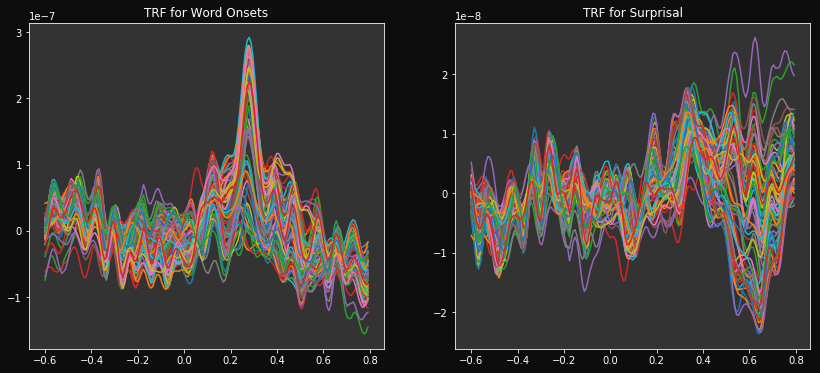

In [44]:
# Average and plug the resulting coef in trf instance for easy plotting
coef_avg = np.mean(np.asarray(coefs), axis=0)
trf.coef_ = coef_avg

trf.plot_single_feature(feat_id=[0,1], figsize=(14,6))

## Compute one _big_ model

Now, instead of computing a model for each story and each participants, we will compute one _grand_ model trained on the concatenation of all data.

**But...**
This is very greedy in memory. Indeed, storing all the EEG data results in a matrix of roughly 2Gb, then the matrix of features, for two features is approximately 100mb, which then results in a design matrix (i.e. time-lagged version of the features) of 12Gb. The latter is then used in different computation, svd or least-square esitmation, which may involve another copy of the matrix... Hence the memory usage can reach a total of 26Gb!!

However it will give a more robust estimate of the TRFs. Fortunately, the implementation of our TRF estimator, allows for a memory-efficient way to compute the coefficient.

The trick used is to accumulate the covariance and cross-covariance matrices used to compute the pseudo-inverse to fit the model. Thus we cut the bulk of the computation (SVD computation) in smaller pieces. Also it can be noted that since the target is always the same (word from stories, similar across participants) the concatenated word-level features can be stored only once and reused to compute the other matrices.

In [52]:
# Loop over stories to get a big concatenation of each story's word features
X = []
wf = {} # make a dictionnary of those, keys are story id
for story_id, story in enumerate(list_stories):
    print("Loading story's word features for ... %s"%(story))
    wo_path = os.path.join(wordfreq_path, list_wordfreq_files[story_id])
    duration_path = os.path.join(env_path, list_env_files[story_id])
    surp_path = os.path.join(surprisal_path, list_surprisal_files[story_id])

    # Create word-level feature object:
    wf[story] = WordLevelFeatures(path_praat_env=duration_path, path_wordonsets=wo_path, path_surprisal=surp_path)
    X.append(wf[story].align_word_features(srate=raw.info['sfreq'], features=('surprisal',)))    
    
X = np.concatenate(X)

INFO:pyeeg.io:Adding feature surprisal
INFO:pyeeg.io:Adding feature surprisal
INFO:pyeeg.io:Adding feature surprisal
INFO:pyeeg.io:Adding feature surprisal
INFO:pyeeg.io:Adding feature surprisal
INFO:pyeeg.io:Adding feature surprisal
INFO:pyeeg.io:Adding feature surprisal
INFO:pyeeg.io:Adding feature surprisal
INFO:pyeeg.io:Adding feature surprisal
INFO:pyeeg.io:Adding feature surprisal
INFO:pyeeg.io:Adding feature surprisal
INFO:pyeeg.io:Adding feature surprisal
INFO:pyeeg.io:Adding feature surprisal
INFO:pyeeg.io:Adding feature surprisal
INFO:pyeeg.io:Adding feature surprisal


Loading story's word features for ... AUNP01
Loading story's word features for ... AUNP02
Loading story's word features for ... AUNP03
Loading story's word features for ... AUNP04
Loading story's word features for ... AUNP05
Loading story's word features for ... AUNP06
Loading story's word features for ... AUNP07
Loading story's word features for ... AUNP08
Loading story's word features for ... BROP01
Loading story's word features for ... BROP02
Loading story's word features for ... BROP03
Loading story's word features for ... FLOP01
Loading story's word features for ... FLOP02
Loading story's word features for ... FLOP03
Loading story's word features for ... FLOP04


In [82]:
%whos

Variable               Type                          Data/Info
--------------------------------------------------------------
NamespaceMagics        MetaHasTraits                 <class 'IPython.core.magi<...>mespace.NamespaceMagics'>
QFileDialog            wrappertype                   <class 'PyQt5.QtWidgets.QFileDialog'>
TRFEstimator           type                          <class 'pyeeg.models.TRFEstimator'>
WordLevelFeatures      type                          <class 'pyeeg.io.WordLevelFeatures'>
coef_avg               ndarray                       175x2x64: 22400 elems, type `float64`, 179200 bytes (175.0 kb)
coefs                  list                          n=195
duration_path          str                           /media/hugo/Storage/data_<...>a/FLOP04/FLOP04_125Hz.Env
eeg_fname              str                           Fs-125-AllChannels-interp<...>_pruned-P14_21032017_.set
eeg_path               str                           /media/hugo/Storage/data_<...>d/BP-0.3-65/Blink_p

In [74]:
# Perform the fit:
trf = TRFEstimator(tmin=-0.6, tmax=0.8, srate=raw.info['sfreq'], alpha=reg_param)
trf.fit(X.repeat(len(list_subjects), axis=0), Y, feat_names=["Word Onsets", "Surprisal"])

INFO:pyeeg.models:Will use lags spanning form tmin to tmax.
To use individual lags, use the `times` argument...


MemoryError: 